# Finding the exact Policy and Value functions in the MountainCar problem

The state space is discretized into a sufficiently large number of intervals along each axis. Then, from each discrete state, one environment step is launched for all possible actions. The following states are stored in the current state. Similarly, in each state, all previous states are remembered from which it can be reached.

The target states are placed in the FIFO queue and the value function for them is assumed to be -1. Then, for the previous states, the value function decreases by -1, and so on. The result is a value function for the entire space.

The agent's policy in each state is calculated using the value function. To do this, in the state, all possible actions are performed and the action with the maximum value is selected. If several actions result in the same maximum values, the policy function is considered undefined.

The resulting policy function is thinned out in areas continuously filled with the same actions. This simplifies the training of the neural network.

In [1]:
import math
from   collections import deque
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

class MountainCar:
    """ 
    We simulate the MountainCar environment 
    https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py
    """
    def __init__(self, goal_velocity=0):
        self.min_position  = -1.2
        self.max_position  = 0.6
        self.max_speed     = 0.07
        self.goal_position = 0.5
        self.goal_velocity = goal_velocity

        self.low  = np.array([self.min_position, -self.max_speed], dtype=np.float32)
        self.high = np.array([self.max_position,  self.max_speed], dtype=np.float32)

        self.force   = 0.001
        self.gravity = 0.0025

        self.state = np.array([0., 0.])

    def step(self, action: int):
        position, velocity = self.state
        velocity += (action - 1) * self.force + math.cos(3 * position) * (-self.gravity)
        velocity = np.clip(velocity, -self.max_speed, self.max_speed)
        position += velocity
        position = np.clip(position, self.min_position, self.max_position)
        if position == self.min_position and velocity < 0:
            velocity = 0

        done = bool(position >= self.goal_position and velocity >= self.goal_velocity)

        self.state = (position, velocity)
        return np.array(self.state, dtype=np.float32), done

#===============================================================================

class Solver:
    def __init__(self, bins = (1001, 1001) ) -> None:
        self.bins = bins
        self.tot_bins = bins[0]*bins[1]
        self.env  = MountainCar()
        self.step = (self.env.high-self.env.low)/self.bins

    #---------------------------------------------------------------------------

    def state(self, indx):
        """ Get the state vector by its index (ix, iv) """
        return self.env.low + indx*self.step

    #---------------------------------------------------------------------------

    def index(self, state):
        """ Get state index (ix, iv) by its vector state """
        indx = ((state - self.env.low)/self.step).astype(np.int)
        indx = np.clip(indx, (0,0), (self.bins[0]-1, self.bins[1]-1))
        return tuple( indx )

    #---------------------------------------------------------------------------

    def x_v(self, i):
        """ i = x*bins[1] + v """
        x = i // self.bins[1]
        return x,  i - x * self.bins[1]      

    #---------------------------------------------------------------------------

    def create_graph(self):     
        """ Create a state transition graph """
        self.open  = deque()   
        self.prev, self.next = [], []
        for _ in range(self.tot_bins):
            self.prev.append([])
            self.next.append([])

        self.minV, goal  = -200, self.index([solver.env.goal_position, 0.])
        self.value = np.full(self.bins, self.minV, dtype=np.float32)
        self.n_vals= 0

        for i1 in range(self.tot_bins):
            ix1, iv1 = self.x_v(i1)            
            s1  = self.state( (ix1, iv1) )
            for a in [0, 1, 2]:
                self.env.state = s1
                s2, done = self.env.step(a)
                ix2, iv2 = self.index(s2)
                i2 = ix2*self.bins[1] + iv2
                if i2 == i1:
                    continue
 
                self.next[i1].append( (i2, a) )
                self.prev[i2].append( i1 )
                if done and self.value[ix2, iv2] == self.minV:      
                    self.value[ix2, iv2] = -1
                    self.open.append(i2)
                    self.n_vals += 1
            if i1 % 1000 == 0:
                print(f"\rGraph : {i1*100./self.tot_bins:3.0f}%,  open len: {len(self.open):5d}", end="")
        print("\nGraph created")

    #---------------------------------------------------------------------------

    def calc_V_function(self):
        """ Calculate the value function from the transition graph """                
        tot = self.bins[0]*self.bins[1]
        while self.open:
            i = self.open.popleft()
            for p in self.prev[i]:
                ipx, ipv = self.x_v(p)
                if self.value[ipx, ipv] == self.minV:
                    ix, iv = self.x_v(i)
                    self.value[ipx, ipv] = self.value[ix, iv] - 1
                    self.open.append(p)
                    self.n_vals += 1

            if self.n_vals % 100 == 0:
                print(f"\rNum values: {100.*self.n_vals/tot:5.2f}% open len: {len(self.open):5d}", end="")
        print(f"\rNum values: {100.*self.n_vals/tot:5.2f}% open len: {len(self.open):5d}")

    #---------------------------------------------------------------------------

    def calc_Q_function(self):
        """ Calculate the Q-function from the transition graph """
        self.Q = np.full(self.bins + (3,), 0, dtype=np.float32)
        i, wrong, tot = 0, 0, self.bins[0]*self.bins[1]
        for ix in range(self.bins[0]):
            for iv in range(self.bins[1]):                
                maxV, maxA, cntMax = -10000, -1, 0
                if len(self.next[i]) != 3: wrong += 1
                for n, a in self.next[i]:
                    nx, nv = self.x_v(n)                    
                    self.Q[ix,iv,a] = -1 + self.value[nx, nv]

                i += 1
                 
        print(f"Num Q-function wrong: {100.*wrong/tot:8.4f}%")
        
    #---------------------------------------------------------------------------

    def calc_policy(self):
        """ Compute policy function using value function and transition graph """
        self.pi = np.full(self.bins, -1., dtype=np.float32)
        wrong, equal, i = 0, 0, 0
        for ix in range(self.bins[0]):
            for iv in range(self.bins[1]):                
                maxV, maxA, cntMax = -10000, -1, 0
                res = []
                for n, a in self.next[i]:
                    nx, nv = self.x_v(n)
                    V = self.value[nx, nv]
                    if V > maxV:
                        maxA = a
                        maxV = V
                        cntMax = 1
                    elif V == maxV:
                        cntMax += 1

                if   cntMax == 0:
                    wrong += 1
                elif cntMax == 1:
                    self.pi[nx, nv] = maxA
                else:
                    equal += 1

                i += 1
                    
        print(f"Num policy wrong: {100.*wrong/self.pi.size:8.4f}%  equal: {100.*equal/self.pi.size:8.4f}%")

    #---------------------------------------------------------------------------

    def thin(self):
        """ Thin out policy function """
        for ix in range(1, self.bins[0]-1):
            for iv in range(1, self.bins[1]-1):
                a = self.pi[ix, iv] 
                if a != -1 and np.sum(self.pi[ix-1: ix+2, iv-1: iv+2]) == 9*a:
                    self.pi[ix, iv] = -1.

    #---------------------------------------------------------------------------

    def smooth(self, M):
        """ Smooth M-matrix """
        pool = nn.AvgPool2d(5, stride=1, padding = 2, count_include_pad=False)
        x = pool(torch.tensor(M, dtype=torch.float32).view(self.bins[0],self.bins[1], 1))        
        return torch.round(x.view(self.bins)).numpy()     

    #---------------------------------------------------------------------------

    def test(self, episodes = 1000, ticks = 200):
        """ Testing with the current pi-function """
        env = gym.make("MountainCar-v0")
        rews = []
        for _ in range(episodes):
            obs =  env.reset()
            tot = 0
            for _ in range(ticks):
                indx   = self.index(obs)
                action = self.pi[indx]
                if action < 0:
                    action = 1
                obs, rew, done, _ = env.step(int(action))

                tot += rew
                if done:
                    break
            rews.append(tot)
        mean, std = np.mean(rews), np.std(rews)
        print(f"Reward: {mean:7.2f} ± {std/episodes**0.5:.1f}, std: {std:.0f}, min: {np.min(rews):.0f}  max: {np.max(rews):.0f}")

## Start of calculations

In our experiments we used bins = (5001, 5001). Building a graph takes a lot of time and requires a lot of CPU.

In [2]:
bins = (1001, 1001)
solver = Solver(bins = bins)

solver.create_graph()
solver.calc_V_function()
solver.calc_Q_function()
solver.calc_policy()

Graph : 100%,  open len: 27869
Graph created
Num values: 100.00% open len:     0
Num Q-function wrong:   0.0695%
Num policy wrong:   0.0000%  equal:  68.5533%


In [3]:
np.save("V",  solver.value)
np.save("Q",  solver.Q)
np.save("pi", solver.pi)

If desired, the value function can be smoothed and the policy function calculated again.

In [4]:
solver.value = solver.smooth(solver.value)

solver.calc_Q_function()
solver.calc_policy()

np.save("V_smooth",    solver.value)
np.save("Q_smooth",    solver.Q)
np.save("pi_smooth",   solver.pi)

Num Q-function wrong:   0.0695%
Num policy wrong:   0.0000%  equal:  68.3689%


To train the neural network, we thin out the policy function in continuous areas.

In [5]:
solver.thin()

solver.calc_policy()

np.save("pi_smooth_thin",    solver.pi)

Num policy wrong:   0.0000%  equal:  68.3689%


## Visualization of policy and value functions

In [6]:
from matplotlib import colors
cmap = colors.ListedColormap(['white', 'blue', 'green', 'red'])

def plot(mat, title, d_ticks=500, bins = (1001, 1001), bar = True, smooth = True):
    def index(state):
        step = (solver.env.high-solver.env.low)/bins
        indx = ((state - solver.env.low)/step).astype(np.int)
        indx = np.clip(indx, (0,0), (bins[0]-1, bins[1]-1))
        return tuple( indx )


    g, m   = index([solver.env.goal_position, 0.]), index([-math.pi/6, 0.])
    x0 = np.array([ index([-0.6, 0.]), index([-0.4, 0.]) ])

    if smooth:
        cmap = 'seismic'
    else:
        cmap = colors.ListedColormap(['gray', 'blue', 'white', 'red'])
        #cmap = colors.ListedColormap(['blue', 'white', 'red'])

    plt.figure(figsize=(8,8))
    plt.imshow(mat.T, interpolation='none', origin='lower', cmap= cmap, alpha=0.5)

    plt.title (title, {'fontsize': 16})
    plt.xlabel('x', {'fontsize': 16}) 
    plt.ylabel('v', {'fontsize': 16}) 
    plt.axhline(g[1], c="black", linewidth=1)
    plt.axvline(g[0], c="black", linewidth=1)
    plt.axvline(m[0], c="black", linewidth=1)
    plt.axvline(x0[0][0], c="black", linewidth=2, ymin = 0.49, ymax = 0.51)
    plt.axvline(x0[1][0], c="black", linewidth=2, ymin = 0.49, ymax = 0.51)
    ticks = range(0, bins[0], d_ticks)
    plt.xticks( ticks, np.round(100*np.linspace(solver.env.low[0], solver.env.high[0], len(ticks)))/100 )
    plt.yticks( ticks, np.round(100*np.linspace(solver.env.low[1], solver.env.high[1], len(ticks)))/100 )
    if bar:
          plt.colorbar(aspect=50) 
    plt.show()

140588 690 174223


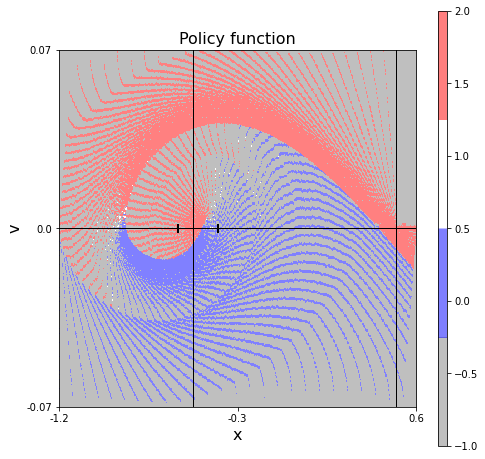

In [7]:
print(np.sum(solver.pi == 0), np.sum(solver.pi == 1), np.sum(solver.pi == 2))

plot(solver.pi, 'Policy function', d_ticks=500,  bins = bins, smooth=False)

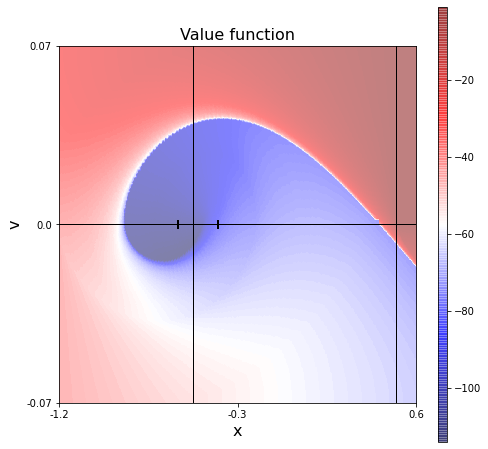

In [8]:
plot(solver.value, 'Value function', d_ticks=500, bins = bins)

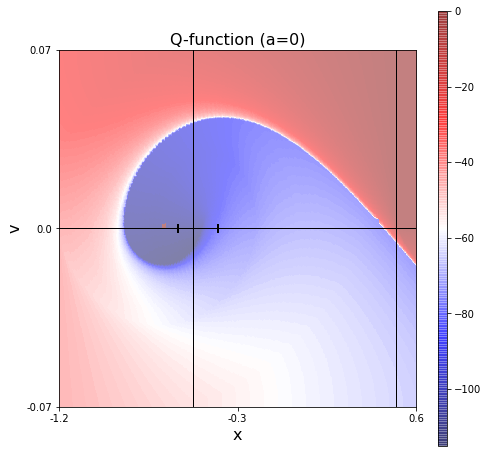

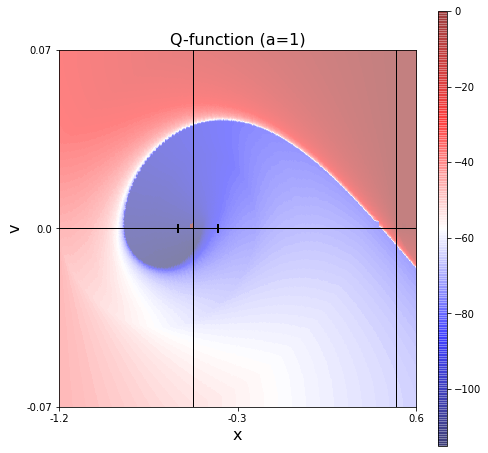

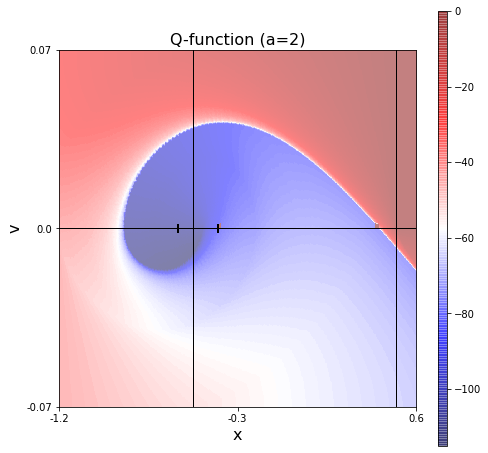

In [9]:
for a in range(3):
    plot(solver.Q[:,:, a], f'Q-function (a={a})', d_ticks=500, bins = bins)

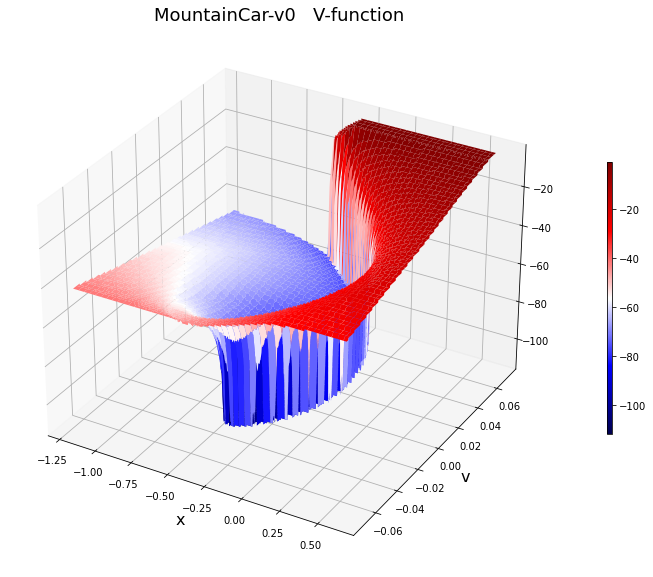

In [11]:
X = np.linspace(solver.env.low[0], solver.env.high[0], solver.bins[0])
Y = np.linspace(solver.env.low[1], solver.env.high[1], solver.bins[0])
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize =(20, 10))
ax = plt.axes(projection ='3d')

plt.title('MountainCar-v0   V-function', fontsize=18)
plt.xlabel('x', fontsize=16);  plt.ylabel('v', fontsize=16);

surf = ax.plot_surface(X, Y, solver.value, cmap=plt.get_cmap('seismic'), linewidth=0, antialiased=True)
#ax.view_init(110, 30)

fig.colorbar(surf, shrink=0.5, aspect=50)

plt.show()